In [109]:
import numpy as np
import custom_hd159062_lnlike as custom_lnlike
from orbitize import sampler,driver,kepler,system,results,lnlike,read_input
import orbitize.kepler
import multiprocessing as mp
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
import pickle
from matplotlib.backends.backend_pdf import PdfPages
import corner
import pandas as pd
from astropy.time import Time

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=17)
plt.rc('axes', linewidth=1)

In [3]:
def M2tperi(M,P,tref):
    Tp = tref - M*P/(2*np.pi)
    return Tp #time of periastron from mean anomaly

def M2tau0(M,P,tref):
    Tp = M2tperi(M,P,tref)
    tau = Tp/P % 1
    return tau #tau from mean anomaly

def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P #fraction of orbit after tperi

def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0+m1))**(1/3) #sma in AU

def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days

In [10]:
path = '../tests/'
data = pd.read_csv(path+'testdata0.csv')
parameters = pd.read_csv(path+'test_params.csv',
                        header=None,names=['m0','m1','P','ecc','argp','lan','inc','tperi','plx','gamma','sigma'])
parameters

,m0,m1,P,ecc,argp,lan,inc,tperi,plx,gamma,sigma
0,1.564479,0.085178,1945.688713,0.122813,2.500799,6.131192,1.073319,500.0,67.913080,91.184153,3.286882
1,1.467623,0.281448,7680.352384,0.541629,3.365739,0.189799,0.766443,500.0,70.358874,43.117884,13.313936
2,1.706174,0.005215,3247.453347,0.440817,5.803546,3.831127,0.651111,500.0,99.960529,26.053640,7.382694
3,1.390054,0.010942,1414.304376,0.219417,3.466953,0.259704,0.889410,500.0,95.129581,92.618208,9.715780
4,2.971407,0.018634,4307.746537,0.418262,2.772717,5.184585,1.509494,500.0,50.011293,37.061491,17.599855


In [11]:
#from period to semi-major axis:
def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0 + m1))**(1/3)
#from semi-major axis to period:
def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days
    
#converting from time of periastron (Tp) to epoch of periastron in P praction (tau) for orbitize parameter
def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P
#converting from practional time of periastron (tau) to time of periastron (Tp) for toy parameter
def Tperi(tau,ref_epoch,P):
    return ref_epoch + tau*P
    
#from our parameter order to orbitize parameter order:
def toy2orb(toy_params):
    orb_order = [2,3,6,4,5,7,8,9,10,1,0]
    orb_realparams = [toy_params[i] for i in orb_order]
    tau = tau0(orb_realparams[5],0.0,orb_realparams[0])
    sma = p2sma(orb_realparams[0],orb_realparams[-1], orb_realparams[-2])
    #mtot = orb_realparams[-1]+orb_realparams[-2]
    orb_realparams[0] = sma
    orb_realparams[5] = tau
    #orb_realparams.append(mtot)
    return orb_realparams #returns real parameters ordered to fit orbitize kepler solver

In [12]:
test_params = toy2orb(parameters.loc[0])
test_params

[3.604014866440558,
 0.12281347690244583,
 1.073318886156944,
 2.5007988258535163,
 6.131192394030213,
 0.25697841420654816,
 67.91307974881711,
 91.1841528143556,
 3.2868818363971983,
 0.08517757310135393,
 1.5644786565229944]

In [13]:
def calc_orbit(theta,time):
    #theta are the parameters (array or list form), and time are the observation epochs (also a list or an array)
    """Arguments (theta):
        [0]: m1 (mass of the star)
        [1]: m2 (mass of orbiting body)
        [2]: P (period in days)
        [3]: ecc (eccentricity between 0.0 and 1.0)
        [4]: argp (argument of periastron)
        [5]: lan (longitude of the ascending node)
        [6]: inc (inclination in radians between 0 and 2pi)
        [7]: tperi (time of periastron in days)
        [8]: plx (parallax in mas)
        [9]: gamma (rv zero-point offset in m/s)
        [10] sigma (jitter in m/s)
        
        time has shape len(N_obs)"""
    #first thing we have to do is figure out the average angular velocity in rad/day:
    n = 2*np.pi/theta[2]
    M = n*(time - theta[7]) #Mean anomaly as a function of time in radians
    M = np.mod(M,2*np.pi)
    
    ecc_arr = np.ones(len(M))*theta[3]
    
    E = kepler._calc_ecc_anom(M,ecc_arr) #eccentric anomaly
    
    nu = 2*np.arctan(np.sqrt((1 + theta[3])/(1 - theta[3]))*np.tan(E/2))
    #print(nu)
    #needed for astrometry data:
    sma = ((theta[2]/365.25)**2*(theta[0] + theta[1]))**(1/3) #calculating the semi-major axis in AU
    
    radius = sma*(1.0 - theta[3]*np.cos(E)) #calculating the radius as a function of E
    
    #X,Y are arrays of length time
    Y = radius*(np.cos(theta[5])*np.cos(theta[4] + nu) - np.sin(theta[5])*np.sin(theta[4] + nu)*np.cos(theta[6])) #DEC
    X = radius*(np.sin(theta[5])*np.cos(theta[4] + nu) + np.cos(theta[5])*np.sin(theta[4] + nu)*np.cos(theta[6])) #RA
    
    dra = X*theta[8]
    ddec = Y*theta[8]
    
    #needed for radial velocity data:
    #Jupiter in solar masses: 0.0009543:
    m_jup = 0.0009543
    
    #radial velocity amplitude in m/s:
    K0 = (28.4329/np.sqrt(1-theta[3]**2))*\
    (theta[1]*np.sin(theta[6])/m_jup)*((theta[0] + theta[1])**(-2/3))*\
    (theta[2]/365.25)**(-1/3)
    #print(K0)
    
    #Radial velocity in m/s:
    argp_star = theta[4] + np.pi
    rv0 = K0*(np.cos(argp_star + nu) + theta[3]*np.cos(argp_star)) + theta[9] #same shape as nu (same shape as time)
    return dra,ddec,rv0

In [14]:
raoff,decoff,rv = calc_orbit(parameters.loc[0],np.arange(0,parameters.loc[0][2]))

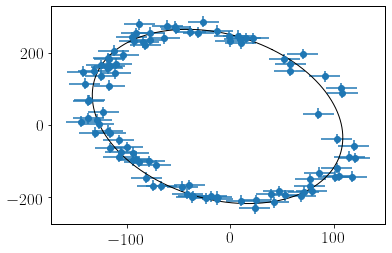

In [15]:
plt.plot(raoff,decoff,'k',lw=1)
plt.errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o')
plt.show()

In [39]:
# system parameters
num_secondary_bodies = 1
system_mass = test_params[-1] # [Msol]
plx = test_params[6] # [mas]
mass_err = 0.05 # [Msol]
plx_err = 0.05 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 100
num_threads = mp.cpu_count() # or a different number if you prefer


my_driver = driver.Driver(
    '../tests/testdata0.csv', 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    system_kwargs = {'fit_secondary_mass':True,
                                  'tau_ref_epoch':0, 'gamma_bounds':(-5000, 5000), 'jitter_bounds':(1e-3, 50)},
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

In [40]:
total_orbits = 5000000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 100 # steps to burn in per walker
thin = 50# only save every 10th step

In [41]:
s = my_driver.sampler

In [42]:
s.run_sampler(total_orbits, burn_steps=0, thin=thin)
chain = my_driver.sampler.chain

Burn in complete


/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.

50000/50000 steps completed
Run complete


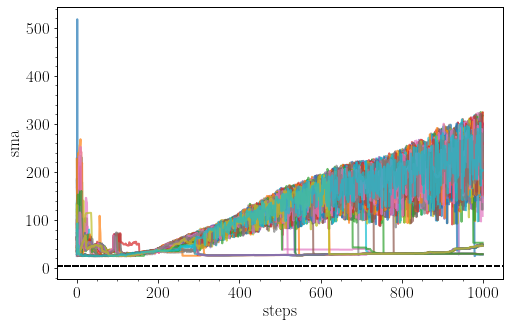

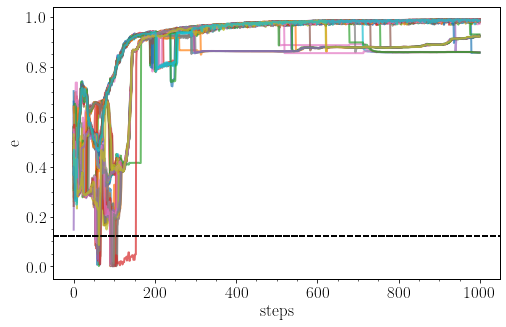

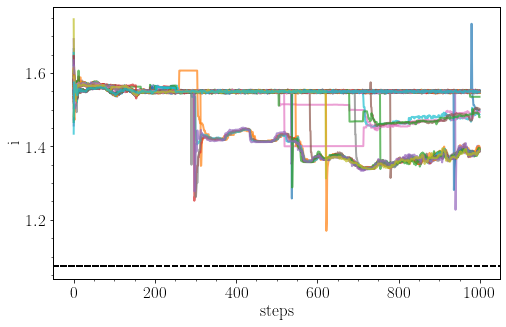

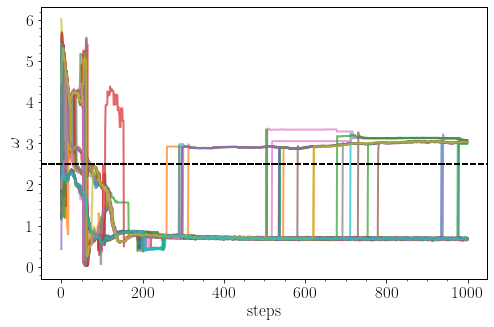

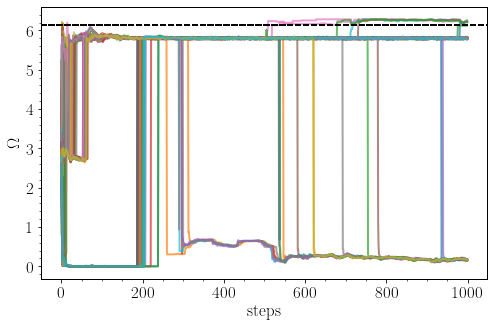

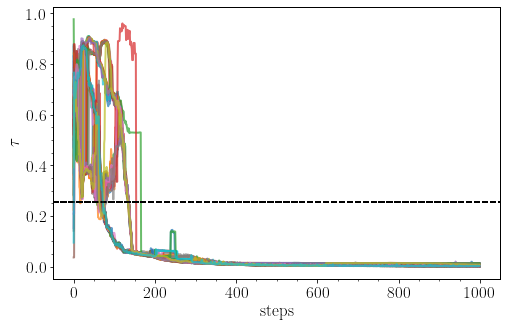

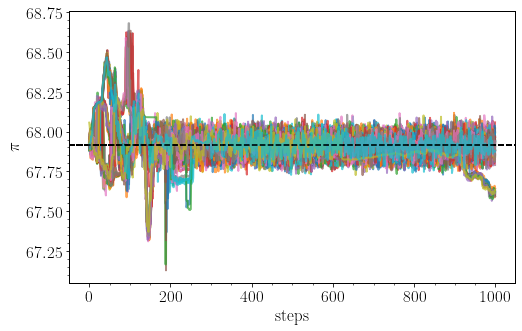

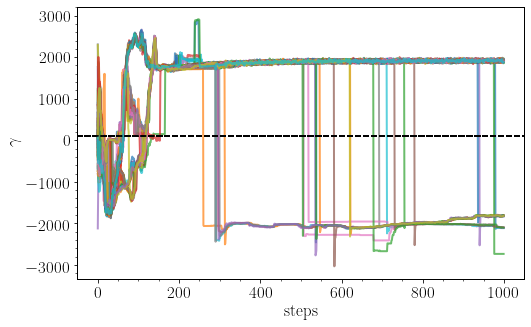

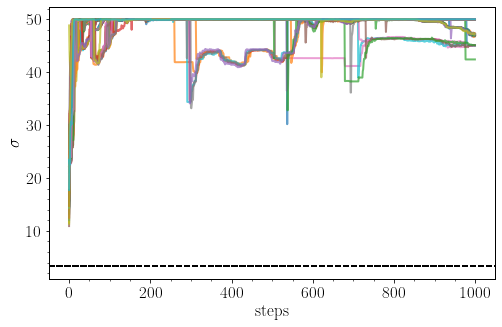

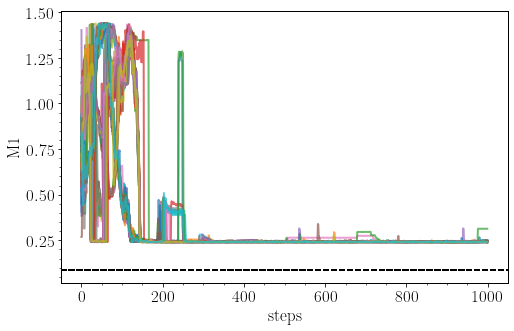

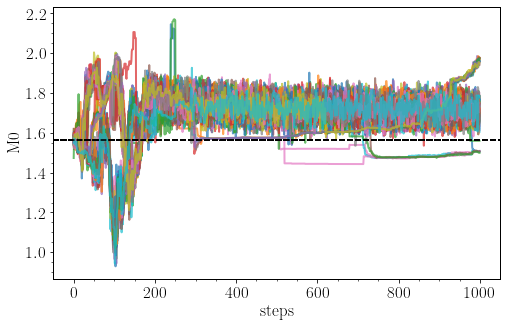

In [43]:
param_names = ['sma','e','i','$\omega$','$\Omega$','$\\tau$','$\pi$','$\gamma$',
               '$\sigma$','M1','M0']
shape = np.shape(chain)
num_steps = shape[2]
num_params = shape[3]
num_walkers = shape[1]
for p in range(num_params):
    pname = param_names[p]
    fig = plt.figure(figsize = (8,5))
    for x in range(num_walkers):
        #makes trend plot
        plt.plot(range(num_steps),my_driver.sampler.chain[0,x,:,p],alpha=0.7,linewidth=2)
        plt.axhline(test_params[p],ls='--',c='k')
    plt.ylabel(pname)
    plt.xlabel('steps')
    plt.minorticks_on()
    plt.show()

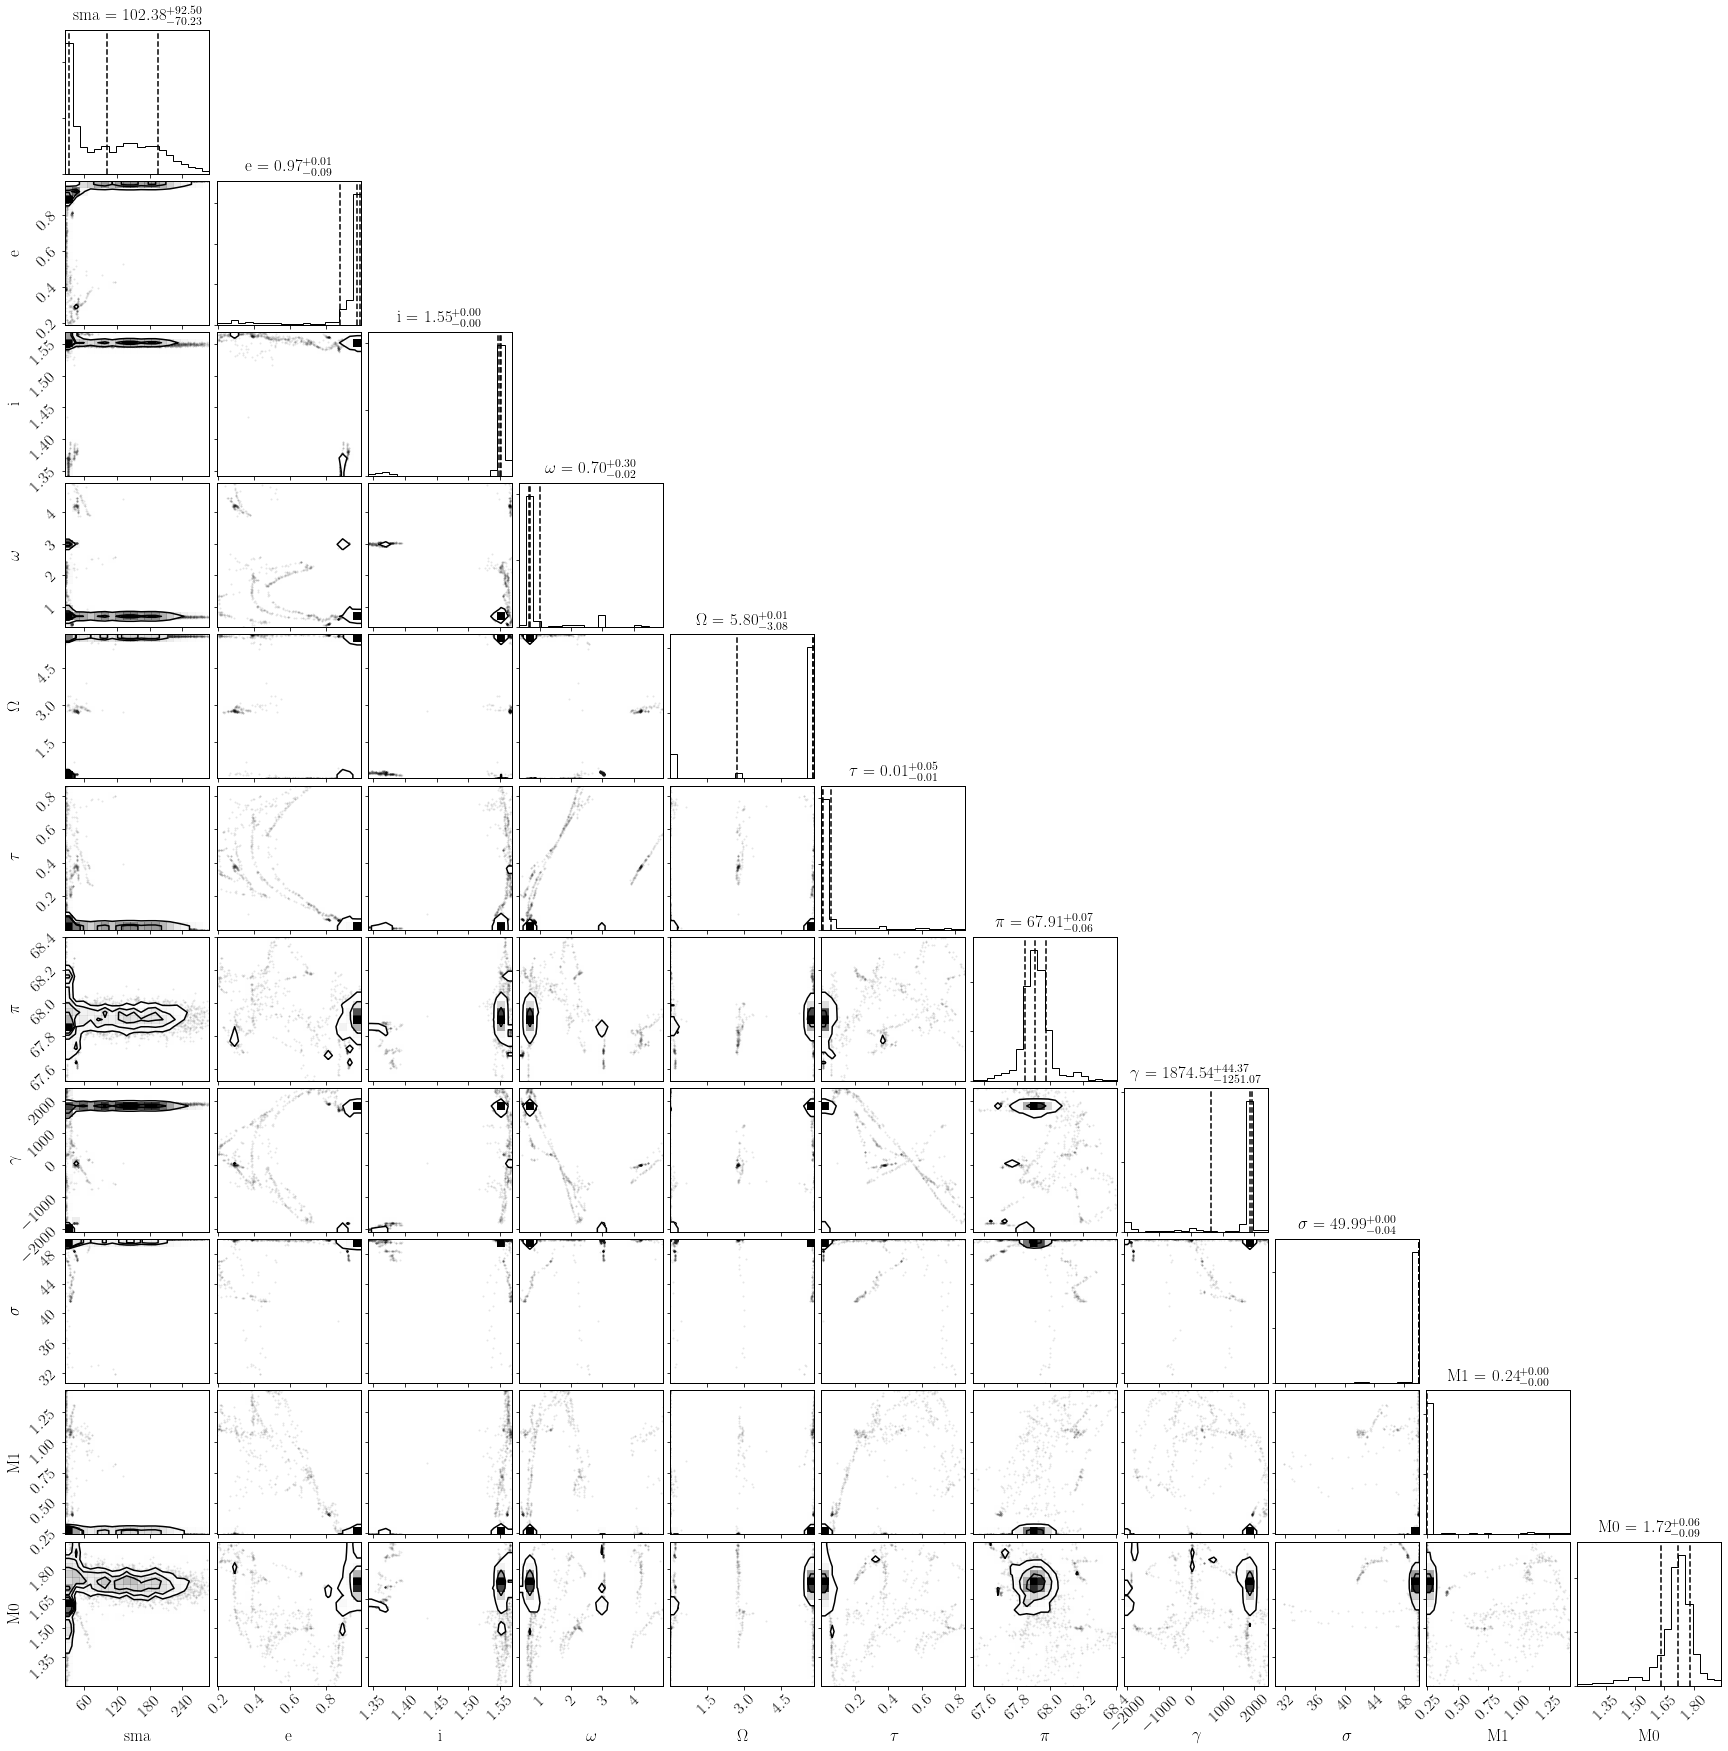

In [44]:
flatchain = np.reshape(chain[0],(-1,11))
flatchain = flatchain[-5000:,:]
corner_fig = corner.corner(flatchain,labels = param_names,quantiles=[0.16,0.5,0.84],
                          show_titles=True,
                           range=np.ones(len(param_names))*0.99,
                           title_kwargs={"fontsize": 17})

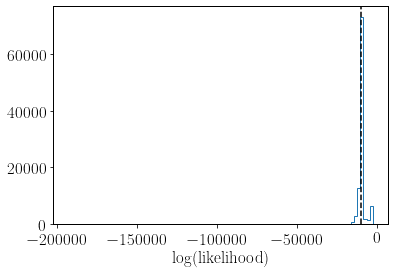

In [45]:
plt.hist(s.lnlikes,bins=100,histtype='step')
plt.axvline(x=np.median(s.lnlikes),c='k',ls='--')
plt.xlabel('$\log(\mathrm{likelihood})$')
#plt.xlim(-2000,2000)
plt.show()

In [46]:
median_pars = np.median(flatchain,axis=0)

In [47]:
#from semi-major axis to period:
def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days

def Tperi(tau,ref_epoch,P):
    return ref_epoch + tau*P

#changing the orbitize paramter output order from orbitize to fit in our calc_orbit function
def orb2toy(orb_params):
    toy_order = [10,9,0,1,3,4,2,5,6,7,8]
    orb_testparams = [orb_params[i] for i in toy_order]
    period = sma2p(orb_testparams[2],orb_testparams[0],orb_testparams[1])
    orb_testparams[2] = period
    tperi = Tperi(orb_testparams[7],0.0,orb_testparams[2])
    orb_testparams[7] = tperi

    return orb_testparams

In [52]:
parameters

,m0,m1,P,ecc,argp,lan,inc,tperi,plx,gamma,sigma
0,1.564479,0.085178,1945.688713,0.122813,2.500799,6.131192,1.073319,500.0,67.913080,91.184153,3.286882
1,1.467623,0.281448,7680.352384,0.541629,3.365739,0.189799,0.766443,500.0,70.358874,43.117884,13.313936
2,1.706174,0.005215,3247.453347,0.440817,5.803546,3.831127,0.651111,500.0,99.960529,26.053640,7.382694
3,1.390054,0.010942,1414.304376,0.219417,3.466953,0.259704,0.889410,500.0,95.129581,92.618208,9.715780
4,2.971407,0.018634,4307.746537,0.418262,2.772717,5.184585,1.509494,500.0,50.011293,37.061491,17.599855


In [53]:
pred_params = orb2toy(median_pars)
print(pred_params)

[1.7216630999630675, 0.24099439901178588, 270070.33593107027, 0.9716241492971486, 0.6970651944293205, 5.798512719645506, 1.5494196573482344, 2337.8930918817773, 67.9093484241937, 1874.5400710896765, 49.993988688628654]


In [54]:
raoff_pred,decoff_pred,rv_pred = calc_orbit(pred_params,np.arange(0,pred_params[2]))

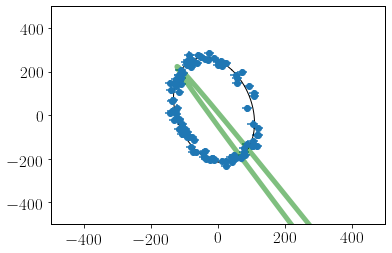

In [51]:
plt.plot(raoff,decoff,'k',lw=1)
plt.plot(raoff_pred,decoff_pred,'g',lw=5,alpha=0.5)
plt.errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.show()

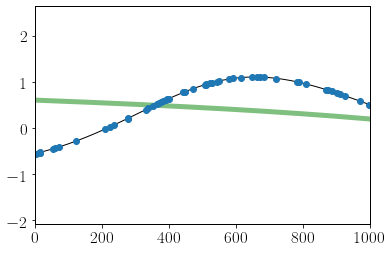

In [55]:
plt.plot(np.arange(0,parameters.loc[0][2]),rv/1000.0,'k',lw=1)
plt.plot(np.arange(0,pred_params[2]),rv_pred/1000.0,'g',lw=5,alpha=0.5)
plt.errorbar(data['epoch'],data['rv'],yerr=data['rv_err'],fmt='o')
plt.xlim(0,1000)
plt.show()

In [56]:
max_params = s.post[np.argmax(s.lnlikes)]
best_params = orb2toy(max_params)
raoff_best,decoff_best,rv_best = calc_orbit(best_params,np.arange(0,best_params[2]))

/Users/rtejada/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


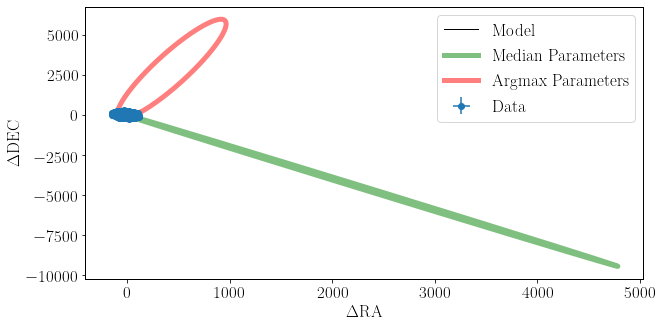

In [57]:
plt.figure(figsize=(10,5))
plt.plot(raoff,decoff,'k',lw=1,label='Model')
plt.plot(raoff_pred,decoff_pred,'g',lw=5,alpha=0.5,label='Median Parameters')
plt.plot(raoff_best,decoff_best,'r',lw=5,alpha=0.5,label='Argmax Parameters')
plt.errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o',label='Data')
plt.xlabel('$\Delta$RA')
plt.ylabel('$\Delta$DEC')
#plt.xlim(-500,500)
#plt.ylim(150,-150)
plt.legend()
plt.show()

In [59]:
test_data = pd.read_csv('/Users/rtejada/Desktop/testdata0.csv')

In [60]:
test_data

,epoch,object,raoff,raoff_err,decoff,decoff_err,rv,rv_err
0,3076.375023,0,NaN,NaN,NaN,NaN,-0.039713,0.005
1,4167.386018,0,NaN,NaN,NaN,NaN,0.838246,0.005
2,2692.552517,0,NaN,NaN,NaN,NaN,-0.330930,0.005
3,1106.525374,0,NaN,NaN,NaN,NaN,-0.905877,0.005
4,191.342902,0,NaN,NaN,NaN,NaN,0.373705,0.005
5,697.614787,0,NaN,NaN,NaN,NaN,-0.477245,0.005
6,4250.581233,0,NaN,NaN,NaN,NaN,0.872475,0.005
7,1064.093397,0,NaN,NaN,NaN,NaN,-0.907861,0.005
8,5040.469865,0,NaN,NaN,NaN,NaN,1.136399,0.005
9,5428.487689,0,NaN,NaN,NaN,NaN,1.002087,0.005


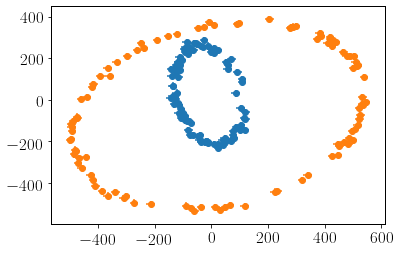

In [61]:
plt.errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o')
plt.errorbar(test_data['raoff'],test_data['decoff'],yerr=test_data['decoff_err'],xerr=test_data['raoff_err'],fmt='o')
#plt.xlim(-500,500)
#plt.ylim(-500,500)
plt.show()

In [77]:
test_data_path = '/Users/rtejada/Desktop/orbitize_mcmc/testdata0_mcmcchains_run3.txt'

In [86]:
with (open(test_data_path, "rb")) as openfile:
    chain = pickle.load(openfile)

In [87]:
print(chain)

[[[[9.08304635e+00 1.81794857e-01 7.14290356e-01 ... 1.76569662e+01
    2.92948540e-01 2.74562548e+00]
   [9.08492287e+00 1.80477327e-01 7.22078251e-01 ... 1.56929035e+01
    2.90742996e-01 2.74235823e+00]
   [9.06482584e+00 1.80864602e-01 7.25053215e-01 ... 1.68881091e+01
    2.88187359e-01 2.72588742e+00]
   ...
   [9.03124644e+00 1.81746333e-01 7.10638583e-01 ... 1.69508293e+01
    2.90771319e-01 2.70297004e+00]
   [9.05665973e+00 1.82611923e-01 7.05882499e-01 ... 1.80347398e+01
    2.95466253e-01 2.72590159e+00]
   [8.97578342e+00 1.83688783e-01 6.98469923e-01 ... 1.68394135e+01
    2.91556578e-01 2.63961753e+00]]

  [[9.07011024e+00 1.85082802e-01 7.19264637e-01 ... 1.81645449e+01
    2.89632779e-01 2.73559319e+00]
   [9.06253129e+00 1.84475588e-01 7.20932858e-01 ... 1.89186496e+01
    2.89042270e-01 2.72748411e+00]
   [9.08799287e+00 1.84833021e-01 7.21448178e-01 ... 1.86644705e+01
    2.90786843e-01 2.74585096e+00]
   ...
   [8.95661209e+00 1.87217838e-01 7.03101334e-01 ... 1.88

In [88]:
np.shape(chain)

(15, 50, 200, 11)

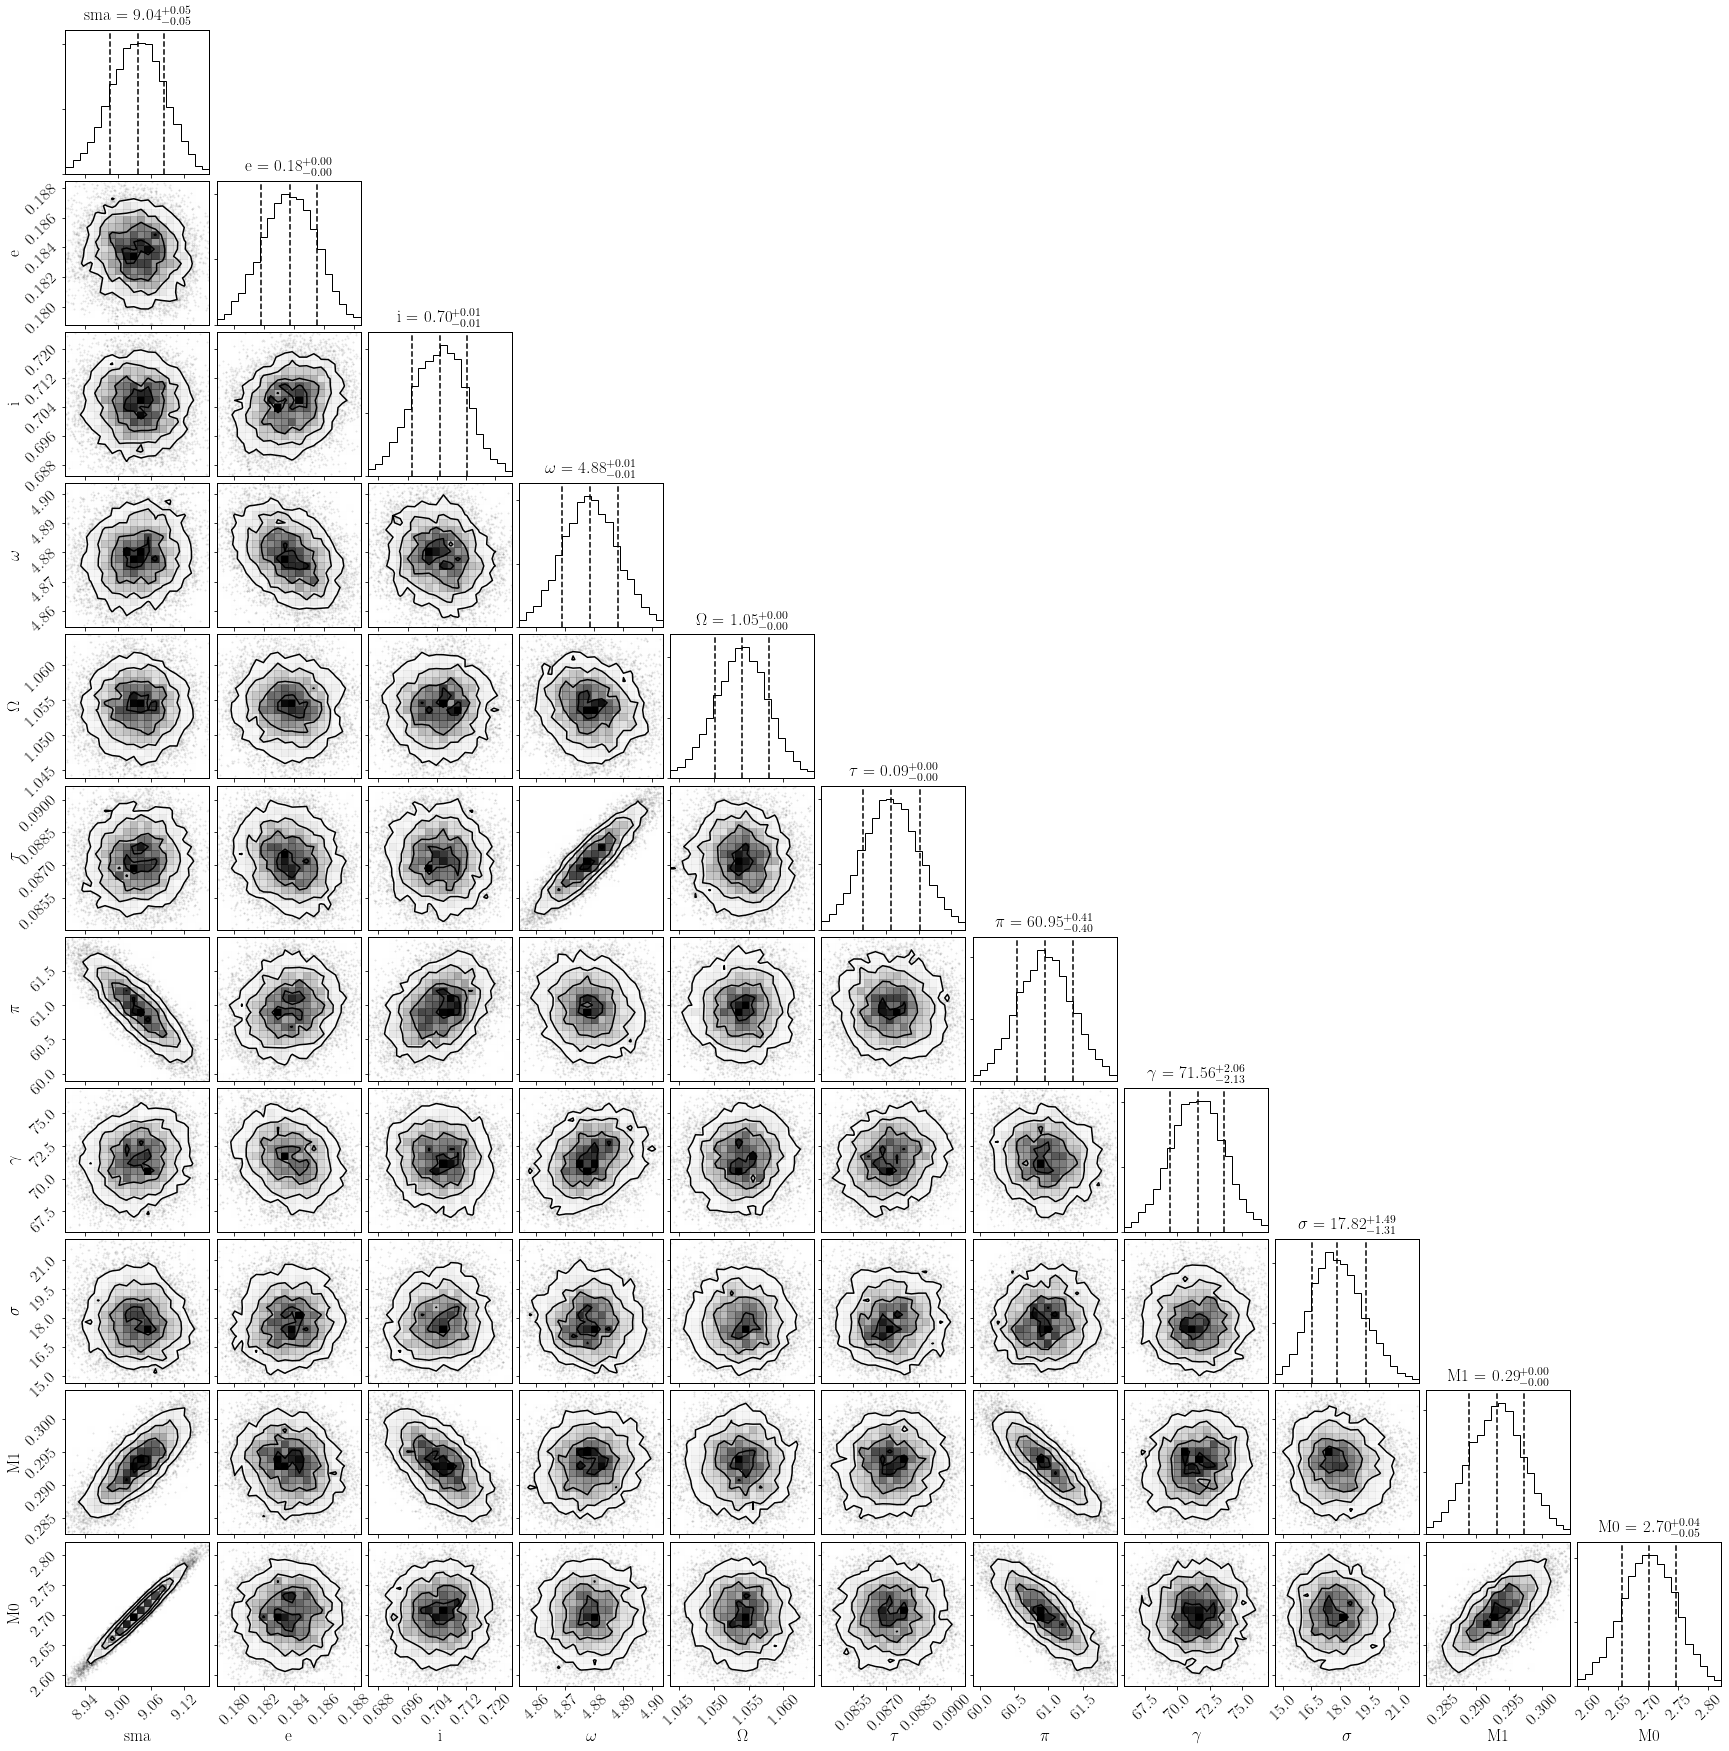

In [90]:
flatchain = np.reshape(chain[0],(-1,11))
#flatchain = flatchain[-5000:,:]
corner_fig = corner.corner(flatchain,labels = param_names,quantiles=[0.16,0.5,0.84],
                          show_titles=True,
                           range=np.ones(len(param_names))*0.99,
                           title_kwargs={"fontsize": 17})

In [108]:
np.shape(flatchain)

(10000, 11)

In [91]:
median_pars = np.median(flatchain,axis=0)

In [92]:
pred_test_params = orb2toy(median_pars)

In [93]:
pred_test_params

[2.7029996805446563,
 0.2932480681423125,
 5731.7160907278,
 0.1836996477481942,
 4.878666361664716,
 1.0540755611753965,
 0.70494286192919,
 500.1140211196907,
 60.95090426198078,
 71.55731577109619,
 17.82093791087472]

In [94]:
raoff_pred_test,decoff_pred_test,rv_pred_test = calc_orbit(pred_test_params,np.arange(0,pred_test_params[2]))

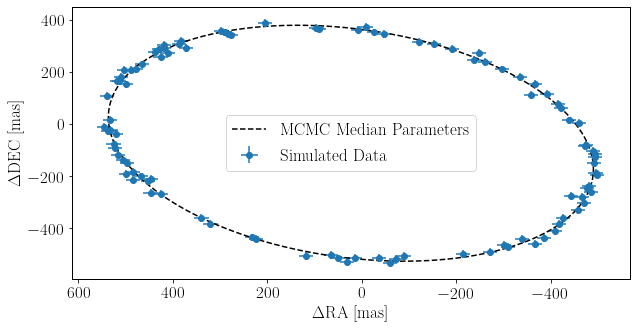

In [104]:
plt.figure(figsize=(10,5))
plt.plot(raoff_pred_test,decoff_pred_test,'k--',label='MCMC Median Parameters')
plt.errorbar(test_data['raoff'],test_data['decoff'],yerr=test_data['decoff_err'],
             xerr=test_data['raoff_err'],fmt='o',label='Simulated Data')
#plt.xlim(-500,500)
#plt.ylim(150,-150)
plt.gca().invert_xaxis()
plt.xlabel('$\Delta$RA [mas]')
plt.ylabel('$\Delta$DEC [mas]')
plt.legend()
plt.show()

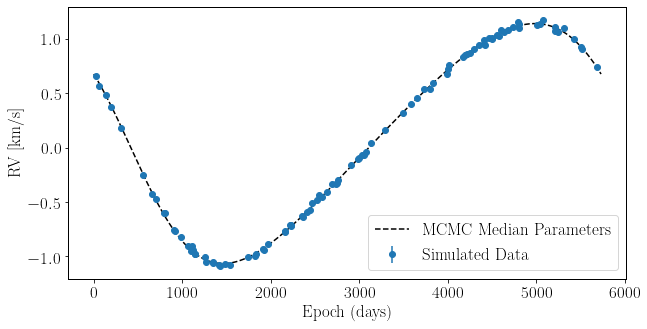

In [107]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,pred_test_params[2]),rv_pred_test/1000.0,'k--',label='MCMC Median Parameters')
plt.errorbar(test_data['epoch'],test_data['rv'],yerr=test_data['rv_err'],fmt='o',label='Simulated Data')
plt.xlabel('Epoch (days)')
plt.ylabel('RV [km/s]')
plt.legend()
plt.show()

In [113]:
test_data_table = read_input.read_file('/Users/rtejada/Desktop/testdata0.csv')

In [116]:
print(median_pars)

[ 9.03626317  0.18369965  0.70494286  4.87866636  1.05407556  0.0872538
 60.95090426 71.55731577 17.82093791  0.29324807  2.70299968]


In [117]:
# system parameters
num_secondary_bodies = 1
system_mass = median_pars[-1] # [Msol]
plx = median_pars[6] # [mas]
mass_err = 0.05 # [Msol]
plx_err = 0.05 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 100
num_threads = mp.cpu_count() # or a different number if you prefer

my_mcmc_test = driver.Driver(
    '/Users/rtejada/Desktop/testdata0.csv', 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    system_kwargs = {'fit_secondary_mass':True,
                                  'tau_ref_epoch':0, 'gamma_bounds':(-5000, 5000), 'jitter_bounds':(1e-3, 50)},
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

In [119]:
# compute the model based on system params
model, jitter = system.System.compute_model(my_mcmc_test.system,flatchain)

# fold data/errors to match model output shape. In particualr, quant1/quant2 are interleaved
data = np.array([test_data_table['quant1'], test_data_table['quant2']]).T
errs = np.array([test_data_table['quant1_err'],
                test_data_table['quant2_err']]).T

# TODO: THIS ONLY WORKS FOR 1 PLANET. Make this a for loop to work for multiple planets.
seppa_indices = np.union1d(my_mcmc_test.system.seppa[0], my_mcmc_test.system.seppa[1])
# compute lnlike
# Rob: added the jitter term here
lnlikes = lnlike.chi2_lnlike(data, errs, model, jitter, seppa_indices)

# return sum of lnlikes (aka product of likeliehoods)
lnlikes_sum = np.nansum(lnlikes, axis=(0, 1))

custom_lnlike_sum = []
for i in range(10000):
    params = flatchain[i,:]
    clnlike = custom_lnlike.custom_chi2_loglike(params)
    custom_lnlike_sum.append(clnlike)

In [120]:
max_params = flatchain[np.argmax(lnlikes_sum)]

In [121]:
np.shape(max_params)

(11,)

In [122]:
best_params = orb2toy(max_params)
raoff_best,decoff_best,rv_best = calc_orbit(best_params,np.arange(0,best_params[2]))

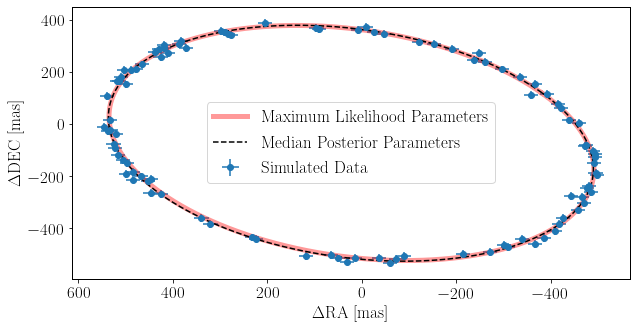

In [135]:
plt.figure(figsize=(10,5))
plt.plot(raoff_best,decoff_best,'r',lw=5,alpha=0.4,label='Maximum Likelihood Parameters')
plt.plot(raoff_pred_test,decoff_pred_test,'k--',label='Median Posterior Parameters')
plt.errorbar(test_data['raoff'],test_data['decoff'],yerr=test_data['decoff_err'],
             xerr=test_data['raoff_err'],fmt='o',label='Simulated Data')
#plt.xlim(-500,500)
#plt.ylim(150,-150)
plt.gca().invert_xaxis()
plt.xlabel('$\Delta$RA [mas]')
plt.ylabel('$\Delta$DEC [mas]')
plt.legend()
plt.savefig('/Users/rtejada/Desktop/simul_data_astr_mcmcresults.pdf')


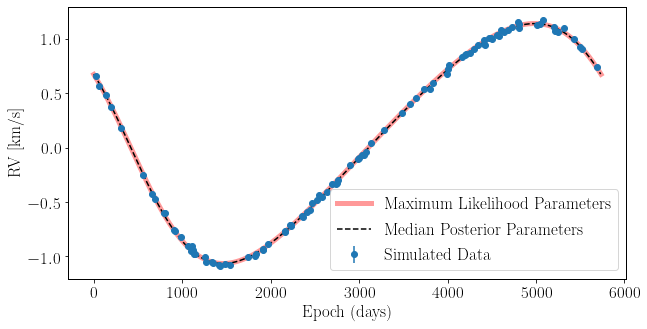

In [136]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,best_params[2]),rv_best/1000.0,'r',lw=5,alpha=0.4,label='Maximum Likelihood Parameters')
plt.plot(np.arange(0,pred_test_params[2]),rv_pred_test/1000.0,'k--',label='Median Posterior Parameters')
plt.errorbar(test_data['epoch'],test_data['rv'],yerr=test_data['rv_err'],fmt='o',label='Simulated Data')
plt.xlabel('Epoch (days)')
plt.ylabel('RV [km/s]')
plt.legend()
plt.savefig('/Users/rtejada/Desktop/simul_data_rv_mcmcresults.pdf')

In [ ]:
max_params = s.post[np.argmax(s.lnlikes)]
best_params = orb2toy(max_params)
raoff_best,decoff_best,rv_best = calc_orbit(best_params,np.arange(0,best_params[2]))